## Телеком 
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### TOC

1. [Открытие данных](#start)
2. [Предобработка и исследование данных](#preprocessing)

    2.1 [Объеденяем все таблицы](#merge)
    
    2.2 [phone](#phone)
    
    2.3 [internet](#internet)
    
    2.4 [personal](#personal)
    
    2.5 [contract](#contract)
    
    2.6 [Конструировние признака, число используемых интернет-продуктов](#n_prod)
    
    2.7 [Разбивка на X, y](#split)
    
    
3. [Моделирование](#model)

    3.1 [Случайный лес](#forest)
    
    3.2 [Градиентный бустинг](#boost)
    
    3.3 [Catboost](#cat)
    
    
4. [Анализ лучшей модели и выбор признаков](#analize)
5. [Выводы](#conclusion)

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from copy import deepcopy

## Открытие данных <a id="start"> </a>

In [104]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
print(len(phone), len(internet), len(personal), len(contract))

6361 5517 7043 7043


In [105]:
phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Сразу переименуем в поле MultipleLines No на MultipleLines_No

In [106]:
phone.loc[phone['MultipleLines']=='No', 'MultipleLines'] = 'MultipleLines_No'

In [107]:
internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [108]:
personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [109]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


##  Предобработка и исследование данных <a id="preprocessing"> </a>

### Объеденяем все таблицы  <a id="merge"> </a>
Объеденяем все таблицы в одну по полю customerID и разбиваем на train и test

In [110]:
df = contract.merge(personal, on='customerID', how='outer')
df =  df.merge(internet, on='customerID', how='outer')
df =  df.merge( phone, on='customerID', how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


In [111]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 20 columns):
customerID          5634 non-null object
BeginDate           5634 non-null object
EndDate             5634 non-null object
Type                5634 non-null object
PaperlessBilling    5634 non-null object
PaymentMethod       5634 non-null object
MonthlyCharges      5634 non-null float64
TotalCharges        5634 non-null object
gender              5634 non-null object
SeniorCitizen       5634 non-null int64
Partner             5634 non-null object
Dependents          5634 non-null object
InternetService     4408 non-null object
OnlineSecurity      4408 non-null object
OnlineBackup        4408 non-null object
DeviceProtection    4408 non-null object
TechSupport         4408 non-null object
StreamingTV         4408 non-null object
StreamingMovies     4408 non-null object
MultipleLines       5089 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 924.3+ KB


In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 941 to 3266
Data columns (total 20 columns):
customerID          1409 non-null object
BeginDate           1409 non-null object
EndDate             1409 non-null object
Type                1409 non-null object
PaperlessBilling    1409 non-null object
PaymentMethod       1409 non-null object
MonthlyCharges      1409 non-null float64
TotalCharges        1409 non-null object
gender              1409 non-null object
SeniorCitizen       1409 non-null int64
Partner             1409 non-null object
Dependents          1409 non-null object
InternetService     1109 non-null object
OnlineSecurity      1109 non-null object
OnlineBackup        1109 non-null object
DeviceProtection    1109 non-null object
TechSupport         1109 non-null object
StreamingTV         1109 non-null object
StreamingMovies     1109 non-null object
MultipleLines       1272 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 231.2+ KB


In [113]:
train = train.fillna('No')

In [114]:
test = test.fillna('No')

### phone <a id="phone"> </a>

In [115]:
train['MultipleLines'].value_counts()

MultipleLines_No    2715
Yes                 2374
No                   545
Name: MultipleLines, dtype: int64

Данные неплохо сбалансированны.
### internet <a id="internet"> </a>

In [116]:
mask = list(internet.columns)

In [117]:
internet_train = train[mask]

In [118]:
internet_train.InternetService.value_counts(dropna= False)

Fiber optic    2474
DSL            1934
No             1226
Name: InternetService, dtype: int64

Внезависимости от типа интернета другими услугами пользуются одинакого часто

### personal <a id="personal"> </a>

In [119]:
mask = ['Partner','Dependents','gender']
train.gender.value_counts()

Male      2836
Female    2798
Name: gender, dtype: int64

Услугами пользуются клиенты обоих полов.

### contract <a id="contract"> </a>

In [120]:
train['TotalCharges'].value_counts()

20.2       10
19.75       9
            8
19.9        7
20.05       6
           ..
1033.95     1
3597.5      1
5243.05     1
734.35      1
3254.35     1
Name: TotalCharges, Length: 5281, dtype: int64

In [121]:
train.loc[contract['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,MultipleLines_No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,MultipleLines_No
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,,Male,0,No,Yes,DSL,Yes,Yes,No,Yes,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,MultipleLines_No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,MultipleLines_No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,MultipleLines_No


Видим, что все пользователи со значением '  ' - новые, значит их траты равны 0.

In [122]:
train.loc[train['TotalCharges']==' ', 'TotalCharges'] = 0
test.loc[test['TotalCharges']==' ', 'TotalCharges'] = 0

In [123]:
train['TotalCharges'] = train['TotalCharges'].astype('float64')
test['TotalCharges'] = test['TotalCharges'].astype('float64')

In [124]:
def time_begin_end(contract):
    contract['End'] = 0
    contract.loc[contract['EndDate']== 'No', 'End'] = 1
    contract.loc[contract['End']== 1, 'EndDate'] = '2020-02-01 00:00:00'
    contract['EndDate'] = pd.to_datetime(contract['EndDate'])
    contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
    contract['ttl'] =  contract['EndDate'] - contract['BeginDate']
    contract['ttl'] =contract['ttl'].dt.days

In [125]:
time_begin_end(train)
time_begin_end(test)

1    4159
0    1475
Name: End, dtype: int64

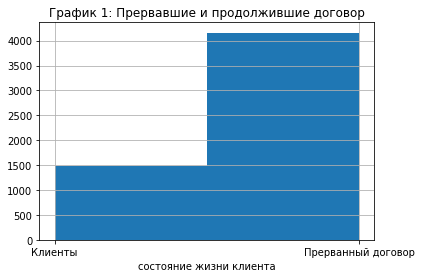

In [126]:
train['End'].hist(bins = 2)
g = 1
plt.title(f'График {g}: Прервавшие и продолжившие договор')
plt.xlabel('состояние жизни клиента')
plt.xticks(np.arange(2), ['Клиенты', 'Прерванный договор'])
train['End'].value_counts()

Text(0.5, 0, 'дата')

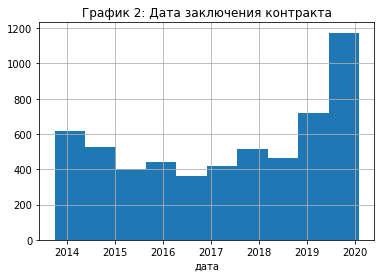

In [127]:
train['BeginDate'].hist(bins=10)
g += 1
plt.title(f'График {g}: Дата заключения контракта')
plt.xlabel('дата')

Видим, что интерес пользователей к продуктам по сосстоянию на 2020 год растет. При этом значительно.

Text(0.5, 0, 'разрывание контракта')

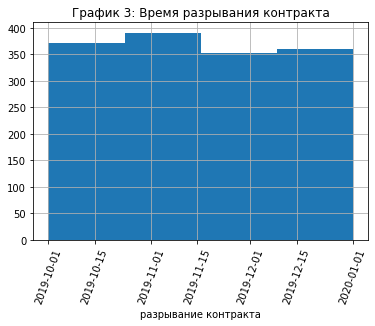

In [128]:
train.loc[train['End']!= 1,'EndDate'].hist(bins=4)
plt.xticks(rotation=70)
g += 1
plt.title(f'График {g}: Время разрывания контракта')
plt.xlabel('разрывание контракта')

А разрывание контракта происходит более равномерно

Text(0.5, 0, 'дни')

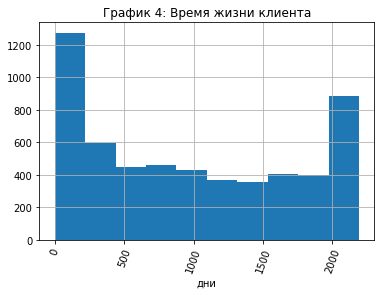

In [129]:
train['ttl'].hist(bins=10)
plt.xticks(rotation=70)
g += 1
plt.title(f'График {g}: Время жизни клиента')
plt.xlabel('дни')

А время жизни очень неравномерно. Видим пики на короткосрочных отношениях и на долгосрочных.

### Конструировние признака, число используемых интернет-продуктов <a id="n_prod"> </a>


In [130]:
def my_dumm(df, prod):
    df['n_prod']=0
    for p in prod:
        df.loc[df[p]!= 'No', 'n_prod'] = df.loc[df[p]!= 'No', 'n_prod'] +1
    
mask = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
my_dumm(train,mask)
my_dumm(test,mask)

### Разбивка на X, y <a id="split"> </a>

In [131]:
mask = list(train.columns)
mask.remove('End')
mask.remove('BeginDate')
mask.remove('EndDate')
mask.remove('customerID')

In [132]:
X_train, y_train = train[mask], train['End']
X_test, y_test = test[mask], test['End']

In [133]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 6924 to 3582
Data columns (total 19 columns):
Type                5634 non-null object
PaperlessBilling    5634 non-null object
PaymentMethod       5634 non-null object
MonthlyCharges      5634 non-null float64
TotalCharges        5634 non-null float64
gender              5634 non-null object
SeniorCitizen       5634 non-null int64
Partner             5634 non-null object
Dependents          5634 non-null object
InternetService     5634 non-null object
OnlineSecurity      5634 non-null object
OnlineBackup        5634 non-null object
DeviceProtection    5634 non-null object
TechSupport         5634 non-null object
StreamingTV         5634 non-null object
StreamingMovies     5634 non-null object
MultipleLines       5634 non-null object
ttl                 5634 non-null int64
n_prod              5634 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 880.3+ KB


In [134]:
categorical_features = mask
categorical_features.remove('ttl')
categorical_features.remove('MonthlyCharges')
categorical_features.remove('TotalCharges')
categorical_features.remove('n_prod')

numeric_features = ['MonthlyCharges','TotalCharges', 'ttl', 'n_prod']

In [137]:
cm = sns.light_palette("green", as_cmap=True)
s = pd.DataFrame(X_train[numeric_features]).corr().style.background_gradient(cmap=cm)
s

Матрица диаграмм рассеяния и таблица корреляции 1: цена, площадь, число комнат, удалённость от центра


,MonthlyCharges,TotalCharges,ttl,n_prod
MonthlyCharges,1,0.649925,0.243047,0.7222
TotalCharges,0.649925,1,0.824623,0.745128
ttl,0.243047,0.824623,1,0.494415
n_prod,0.7222,0.745128,0.494415,1


Матрица диаграмм рассеяния 1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3cdc685c90>,
      dtype=object)

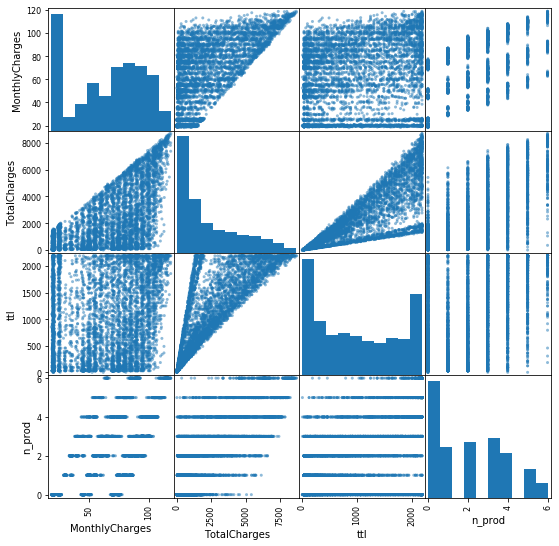

In [139]:
m = 1
print(f'Матрица диаграмм рассеяния {m}')

pd.plotting.scatter_matrix(X_train[numeric_features], figsize=(9, 9))

Убираем мультиколлинеарность

In [101]:
X_train = X_train.drop(['TotalCharges', 'n_prod'], axis=1)
X_test = X_test.drop(['TotalCharges', 'n_prod'], axis=1)

In [102]:
numeric_features = ['MonthlyCharges', 'ttl']

## Моделирование <a id="model"> </a>
Используем 3 модели может это будут случайный лес, градиентный бустинг и катбуст.
Но для начала опишем препроцессор для обработки для первых двух видов моделей.

In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='error', drop = 'first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [38]:
enc = OneHotEncoder( drop='first', sparse=False)
x = enc.fit_transform(X_train[categorical_features])
c = numeric_features+list(enc.get_feature_names(categorical_features))

### Случайный лес  <a id="forest"> </a>

In [39]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier(random_state=12345, class_weight='balanced',n_jobs=-1))])


param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__max_depth': [8,16],
    'classifier__n_estimators': [200,600,1000]
}

grid_search = GridSearchCV(pipe, param_grid, cv=3,scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [40]:
grid_search.best_params_

{'classifier__max_depth': 8,
 'classifier__n_estimators': 1000,
 'preprocessor__num__imputer__strategy': 'mean'}

In [41]:
grid_search.best_score_

0.8524738077480196

In [42]:
model_forest_predictions = grid_search.predict_proba(X_test)[:,1]

print("roc_auc:", roc_auc_score(y_test.values, model_forest_predictions))
print("accuracy_score:", accuracy_score(y_test.values, grid_search.predict(X_test)))

roc_auc: 0.8635405466229902
accuracy_score: 0.78708303761533


### Градиентный бустинг <a id="boost"> </a>

In [43]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', GradientBoostingClassifier())])



param_grid =  {'preprocessor__num__imputer__strategy': ['mean', 'median'],
               'classifier__learning_rate': [ 0.2, 0.3],
               'classifier__subsample'    : [0.9, 1],
               'classifier__n_estimators' : [1000,2000],
               'classifier__max_depth'    : [9,10],
               'classifier__min_samples_split': [0.4, 0.5],
               'classifier__min_samples_leaf': [0.1, 0.3]
                 }
grid_gbc = GridSearchCV(pipe, param_grid, cv=3,scoring='roc_auc', n_jobs = -1,verbose=3)
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean, score=0.861, total=   3.7s
[CV] classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean, score=0.875, total=   3.7s
[CV] classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV]  classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=mean, score=0.875, total=   3.9s
[CV] classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=median 
[CV]  classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=median, score=0.862, total=   3.7s
[CV] classifier__learning_rate=0.2, classifier__max_depth=9, classifier__min_samples_leaf=0.1, classifier__min_samples_split=0.4, classifier__n_estimators=1000, classifier__subsample=0.9, preprocessor__num__imputer__strategy=median 
[CV]  classifi

[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 29.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [44]:
grid_gbc.best_params_

{'classifier__learning_rate': 0.3,
 'classifier__max_depth': 9,
 'classifier__min_samples_leaf': 0.1,
 'classifier__min_samples_split': 0.5,
 'classifier__n_estimators': 2000,
 'classifier__subsample': 1,
 'preprocessor__num__imputer__strategy': 'mean'}

In [45]:
grid_gbc.best_score_

0.8944313057810722

In [46]:
GBC_predictions = grid_gbc.predict_proba(X_test)[:,1]

print("roc_auc:", roc_auc_score(y_test, GBC_predictions))
print("accuracy_score:", accuracy_score(y_test.values, grid_gbc.predict(X_test)))

roc_auc: 0.9181065739791453
accuracy_score: 0.8644428672817601


### CatBoost   <a id="cat"> </a>

In [55]:

model_cat = CatBoostClassifier(random_seed=12345) 
scaler = StandardScaler().fit(X_train[numeric_features])
X_train[numeric_features]=scaler.transform(X_train[numeric_features])
X_test[numeric_features]=scaler.transform(X_test[numeric_features])
params = {'iterations': [500],
          'depth': [5,6,7],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'learning_rate': [0.1, 0.01]
         }

grid_cat = GridSearchCV(model_cat, params, cv=3, scoring='roc_auc', n_jobs = -1,verbose=3)
grid_cat.fit(X_train, y_train, cat_features=categorical_features)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss, score=0.907, total=  18.8s
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss, score=0.903, total=  18.6s
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   37.3s remaining:    0.0s


[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=Logloss, score=0.914, total=  18.1s
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy 
[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy, score=0.907, total=  19.3s
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy 
[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy, score=0.903, total=  19.5s
[CV] depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy 
[CV]  depth=5, iterations=500, leaf_estimation_iterations=10, learning_rate=0.1, logging_level=Silent, loss_function=CrossEntropy, score=0.91

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 12.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3d374dc910>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [5, 6, 7], 'iterations': [500],
                         'leaf_estimation_iterations': [10],
                         'learning_rate': [0.1, 0.01],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=3)

In [56]:
grid_cat.best_params_

{'depth': 5,
 'iterations': 500,
 'leaf_estimation_iterations': 10,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

In [57]:
grid_cat.best_score_

0.907876574497611

In [58]:
cat_predictions = grid_cat.predict_proba(X_test)[:,1]

print("roc_auc:", roc_auc_score(y_test, cat_predictions))
print("accuracy_score:", accuracy_score(y_test, grid_cat.predict(X_test)))

roc_auc: 0.9249068540421594
accuracy_score: 0.8750887154009936


## Анализ лучшей модели и выбор признаков<a id=  "analize"> </a>
На основе метрики AUC-ROC и дополнительной метрики Accuracy лучшей моделью оказалась CatBoostClassifier. Попробуем убрать не важные в обучении признаки. 

Попробуем убрать и уточнения типа интернета

In [59]:
X_train_copy =deepcopy(X_train)
X_test_copy = deepcopy(X_test)

In [60]:
X_train.loc[X_train['InternetService']!= 'No', 'InternetService'] = 'Yes'
X_test.loc[X_test['InternetService']!= 'No', 'InternetService'] = 'Yes'
model_cat = CatBoostClassifier(random_seed=12345, depth=5,iterations=500,leaf_estimation_iterations=10,learning_rate= 0.1,logging_level='Silent',loss_function='Logloss') 

model_cat.fit(X_train, y_train, cat_features=categorical_features)

cat_predictions = model_cat.predict_proba(X_test)[:,1]

print("roc_auc:", roc_auc_score(y_test, cat_predictions))
print("accuracy_score:", accuracy_score(y_test, model_cat.predict(X_test)))

roc_auc: 0.9267322647595708
accuracy_score: 0.8765081618168914


Показатели немного улучшились.

Попробуем убрать уточнение о типе сети в телефоне

In [61]:
X_train.loc[X_train['MultipleLines']=='MultipleLines_No', 'MultipleLines'] = 'Yes'
X_test.loc[X_test['MultipleLines']=='MultipleLines_No', 'MultipleLines'] = 'Yes'

model_cat.fit(X_train, y_train, cat_features=categorical_features)

cat_predictions = model_cat.predict_proba(X_test)[:,1]

print("roc_auc:", roc_auc_score(y_test, cat_predictions))
print("accuracy_score:", accuracy_score(y_test, model_cat.predict(X_test)))

roc_auc: 0.9217686479457879
accuracy_score: 0.872249822569198


Показатели ухудшились, не меняем.

In [62]:
X_train['MultipleLines'] = X_train_copy['MultipleLines']
X_test['MultipleLines'] = X_test_copy['MultipleLines']

In [63]:
f_imp = pd.DataFrame(zip(X_train.columns, model_cat.feature_importances_), columns=['feature_name', 'importance']).sort_values(by='importance')
f_imp

,feature_name,importance
8,InternetService,0.517634
7,Dependents,0.587406
11,DeviceProtection,0.632628
4,gender,0.784662
5,SeniorCitizen,0.806901
6,Partner,0.949790
14,StreamingMovies,0.958872
13,StreamingTV,1.065813
10,OnlineBackup,1.079126
15,MultipleLines,1.345469


Будем удалять по одному признаку и смотреть на score

In [64]:
f_list = list(f_imp['feature_name'])
col_list = list(f_imp['feature_name'])
result = pd.DataFrame(columns=['Признаков', 'roc_auc', 'accuracy'])

categorical_n = deepcopy(categorical_features)
for el in f_list:
    if len(col_list)!=1:
        col_list.remove(el)
        try:
            categorical_n.remove(el)
        except ValueError:
            pass
        model_cat.fit(X_train[col_list], y_train, cat_features=categorical_n)
        cat_predictions = model_cat.predict_proba(X_test[col_list])[:,1]
        cat_p = model_cat.predict(X_test[col_list])
        result.loc[len(result)]=([len(col_list),roc_auc_score(y_test, cat_predictions),  accuracy_score(y_test, cat_p)])


In [65]:
result.sort_values(by='roc_auc').style.background_gradient(cmap=cm)

,Признаков,roc_auc,accuracy
1,15,0.923617,0.87296
0,16,0.924377,0.87154
3,13,0.926553,0.874379
4,12,0.927152,0.875089
10,6,0.927384,0.883605
8,8,0.92809,0.877928
2,14,0.928948,0.883605
7,9,0.928959,0.881476
11,5,0.929697,0.879347
6,10,0.92981,0.875089


Лучшая модель по критериям нашего проекта на 3 признаках. Посмотрим на другие метрики

In [66]:
col_list = list(f_imp['feature_name'])
categorical_n = deepcopy(categorical_features)

for el in f_list:
    if len(col_list)!=2:
        col_list.remove(el)
        try:
            categorical_n.remove(el)
        except ValueError:
            pass
      
model_cat.fit(X_train[col_list], y_train, cat_features=categorical_n)
cat_predictions = model_cat.predict_proba(X_test[col_list])[:,1]
cat_p = model_cat.predict(X_test[col_list])


print("recall_score:",recall_score(y_test, cat_p))
print("precision_score:", precision_score(y_test, cat_p) )

recall_score: 0.9655172413793104
precision_score: 0.8966148215919487


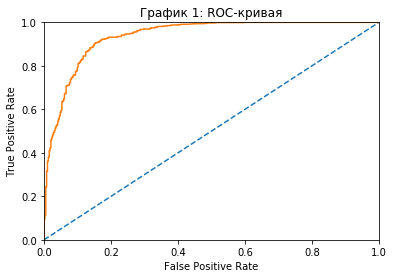

In [67]:
auc_roc = roc_auc_score(y_test, cat_predictions)

probabilities_valid = model_cat.predict_proba(X_test[col_list])
probabilities_one_valid = probabilities_valid[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('График 1: ROC-кривая')
plt.show()

## Выводы <a id="con`clusion"> </a>

Наиболее точной по метрикам AUC-ROC и accuracy_score оказалась модель CatBoostClassifier. Убирая незначимые признаки можно еще ненамного увеличить значения этих метрик. При этом самой небольшой метрикой оказался precision_score: около 12% не собирающихся уходить получат промокод. recall же около 4% - столько уходящих недождутся своего промо.
Чтобы получить лучший результат мы использовали всего 4 признака: ttl (время жизни клиента), MonthlyCharges, Type, PaymentMethod. Все они были получены из таблицы контракт.